# MLP with normalization techniques

## Data Preprocessing 

In [240]:
len(words)

32033

In [21]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}
print(stoi, itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [22]:
# 1. Define a device variable. If a GPU is available, use it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available CUDA devices
    num_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_devices)

    # Get information about the current device
    current_device_id = torch.cuda.current_device()
    print("Current device ID:", current_device_id)

    # Get the name of the current device
    device_name = torch.cuda.get_device_name(current_device_id)
    print("Device name:", device_name)

    # Get detailed device properties
    device_props = torch.cuda.get_device_properties(current_device_id)
    print("Device properties:", device_props)

    # Get memory information
    memory_allocated = torch.cuda.memory_allocated(current_device_id)
    memory_reserved = torch.cuda.memory_reserved(current_device_id)
    print("Memory allocated:", memory_allocated)
    print("Memory reserved:", memory_reserved)
else:
    print("CUDA is not available.")

Using device: cuda
Number of CUDA devices: 1
Current device ID: 0
Device name: Quadro P5000
Device properties: _CudaDeviceProperties(name='Quadro P5000', major=6, minor=1, total_memory=16272MB, multi_processor_count=20)
Memory allocated: 0
Memory reserved: 0


## Hyperparameters

In [30]:
runs = {}

In [225]:
for i, v in runs.items():
    print(f"{i} \n eval_loss: {v['eval_loss'].item():.4f}, train_loss: {v['train_loss'].item():.4f},  train_time: {v['time']:.2f}s")

# > previous best result from parameter tuning
# block_size_5__embedding_size_10__hidden_layer_size_200__batch_size_128__learning_rates_A_0.15__learning_rates_B_0.01__epochs_100000___A 
# eval_loss: 2.1952, train_loss: 2.1631,  train_time: 165.22s
    
# > scaling W2 so the logits are not too big 
# block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_100000____W1_scaling_factor 
# eval_loss: 2.1599, train_loss: 2.1056,  train_time: 124.18s
    
# > making sure tanh doesn't oversaturate by scaling down Q1
# block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_100000___A 
# eval_loss: 2.1393, train_loss: 2.0990,  train_time: 124.12s

# > kaimin activation
# block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_100000____kaiming 
# eval_loss: 2.1258, train_loss: 2.0680,  train_time: 118.84s

# > batch norm
# tes_A_0.1__learning_rates_B_0.02__epochs_100000____batch_norm_2 
# eval_loss: 2.1641, train_loss: 2.1409,  train_time: 196.01s

# > removed batch norm, best run so far
# block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_300000____removed_batchnorm 
# eval_loss: 2.1177, train_loss: 2.0359,  train_time: 359.38s



block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_1000___A 
 eval_loss: 2.8409, train_loss: 2.8461,  train_time: 1.22s
block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_10000___A 
 eval_loss: 2.2618, train_loss: 2.2591,  train_time: 11.47s
block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_100000___A 
 eval_loss: 2.1393, train_loss: 2.0990,  train_time: 124.12s
block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_10___A 
 eval_loss: 3.5051, train_loss: 3.5115,  train_time: 0.03s
block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_100000____W1_scaling_factor 
 eval_loss: 2.1599, train_loss: 2.1056,  train_time: 124.18s
block_size_3__e

In [241]:
RUN_NAME = "__removed_batchnorm"
hyperparams = {
'block_size': 3,
'embedding_size': 10,
'hidden_layer_size': 200,
'batch_size': 32*4,
'learning_rates_A': 0.10,
'learning_rates_B': 0.02,
'epochs': 10000
}


def hyperparams_to_run_name():
    if RUN_NAME == "": return "last_run_(not_logged)"
    return ''.join([f"{k}_{v}__" for k, v in hyperparams.items()]) + RUN_NAME

hyperparams_to_run_name()

block_size = hyperparams['block_size']
embedding_size = hyperparams['embedding_size']
epochs = hyperparams['epochs']
learning_rates = [0, 0]
learning_rates[0] = hyperparams['learning_rates_A']
learning_rates[1] = hyperparams['learning_rates_B']
hidden_layer_size = hyperparams['hidden_layer_size']
batch_size = hyperparams['batch_size']

## Training Data

In [44]:
import torch



def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(context, ix)
            #print(''.join(itos[i] for i in context), '->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



## Model

### Initialization

In [128]:
# iniitalization at the beginnning should be
import torch
-torch.log(torch.tensor([1/27])) 
# this would be loss for uniform distribution for 27 classes

logits = torch.zeros(8, dtype=torch.float)
logits = torch.tensor([2,10,5,3,30,-10,2,3], dtype=torch.float)
logits = torch.randn(8) * 10
# if the numebers are high unlikely you will be guessing the right bucket
# we want to set logits to be close to uniform distributioun, for instance all equal, 
# to get loss that's ckloser to uniform distribution loss
print(logits)
probs = torch.softmax(logits, dim=0)
-torch.log(probs[2])

# if we oversaturate the tanh there is going to be dead neurons (weight > 0.99)
# in the whole forward pass they will never get activated

# you want to have unit gaussian over the net
# if you multiply to gaussian the variance increase

# https://arxiv.org/abs/1502.01852
# Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification

# batch norm + layer norm + residual network + adam optimizer
# make it so initialization less important

tensor([ -2.1025, -28.6530,   1.9339, -13.5277,   8.4183,  -8.7077,  24.0220,
         -6.8274])


tensor(22.0881)

In [246]:

C = torch.randn((27, embedding_size), device=device)
W1_multiplier = (5/3) / ((embedding_size * block_size) ** 0.5)
W1 = torch.randn((embedding_size * block_size, hidden_layer_size), device=device) * W1_multiplier
b1 = torch.randn(hidden_layer_size, device=device) * 0
W2 = torch.randn((hidden_layer_size, 27), device=device) * 0.1
b2 = torch.randn(27, device=device) * 0 
bn_bias = torch.zeros((1, hidden_layer_size), device=device)
bn_gain = torch.zeros((1, hidden_layer_size), device=device)
bn_running_mean = torch.zeros((1, hidden_layer_size), device=device)
bn_running_std = torch.zeros((1, hidden_layer_size), device=device)

parameters = [C, W1, b1, W2, b2]
#parameters += [ bn_bias, bn_gain]

for p in parameters:
  p.requires_grad = True

print(sum(p.nelement() for p in parameters))

lri = []
lossi = []
lossepochs = []

#logits = h @ W2 + b2
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdims=True)

#loss = -prob[torch.arange(32), Y].log().mean() 
# here the mean means we take the mean of all the losses
# of all individual training examples

#loss == F.cross_entropy(logits, Y)

#lre = torch.linspace(-3, 0, 1000)
#lrs = 10**lre`b
#lrs.shape

11897


In [144]:
W1.std(), W2.std()

(tensor(0.3012, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.0985, device='cuda:0', grad_fn=<StdBackward0>))

## Training


In [129]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
print(ix.shape)
print(Xtr.shape)
x = Xtr[ix]
print(x.shape)
print(C.shape)
print(C[x].shape)
emb = C[x]
emb.view(-1,  block_size * embedding_size).shape

torch.Size([32])
torch.Size([182580, 3])
torch.Size([32, 3])
torch.Size([27, 10])
torch.Size([32, 3, 10])


torch.Size([32, 30])

In [164]:
preact_h.shape, preact_h.mean(), preact_h.std()

(torch.Size([32, 200]),
 tensor(0.0999, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.8816, device='cuda:0', grad_fn=<StdBackward0>))

In [166]:
# batch normalization, we take the hidden state, 
# and for each element in the hidden state we normalize it across the batch
preact_h.mean(0, keepdim=True).shape, preact_h.std(0, keepdim=True).shape

# and then we add bias and scale (one per hidden layer parameter) so that nn can retain information after 
# normalizing

# issue with batch norm is that it couples different examples, 
# because it acts as a regularizer, non deterministic over single example 

(torch.Size([1, 200]), torch.Size([1, 200]))

In [247]:
import torch.nn.functional as F


    
import time
start_time = time.time()
    
for epoch in range(epochs):
    
    if epoch % 10000 == 0:
        print(epoch)
    
    learning_rate = learning_rates[0] if epoch < int(epochs/2) else learning_rates[1]
    
    #minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)

    # forward pass|
    emb = C[Xtr[ix]]
    
    preact_h = emb.view(-1, block_size * embedding_size) @ W1 + b1
    
    # batch norm
    #preact_h_mean = preact_h.mean(0, keepdim=True)
    #preact_h_std = preact_h.std(0, keepdim=True)
    #preact_h = (preact_h - preact_h_mean) / preact_h_std
    #preact_h = preact_h * bn_gain + bn_bias 
    
    with torch.no_grad():
        bn_running_mean = 0.99 * bn_running_mean + 0.01 * preact_h_mean
        bn_running_std = 0.99 * bn_running_std + 0.01 * preact_h_std
    
    h = torch.tanh(preact_h)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data -= learning_rate * p.grad

    if epoch % 50 == 0:
        #lri.append(lre[i].item
        lossi.append(loss.item())
        lossepochs.append(epoch)
        
end_time = time.time()

    
print("train() COMPLETED")


0
train() COMPLETED


In [213]:
bn_running_std

tensor([], device='cuda:0', size=(0, 200))

2.1836800575256348
2.1663262844085693


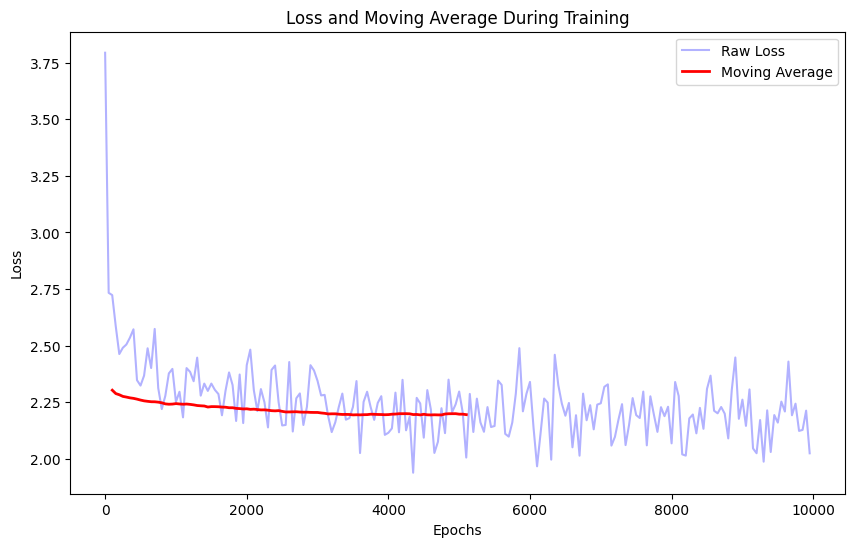

In [248]:
@torch.no_grad()
def eval():
    # forward pass
    
    def inference(X, Y):
        emb = C[X]
        preact_h = emb.view(-1, block_size * embedding_size) @ W1 + b1

        # batch norm
        #preact_h = (preact_h - bn_running_mean) / bn_running_std
        #preact_h = preact_h * bn_gain + bn_bias 

        h = torch.tanh(preact_h)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y)
        return loss

    eval_loss = inference(Xval, Yval)
    print(eval_loss.item())

    train_loss = inference(Xtr, Ytr)
    print(train_loss.item())
  

    run_name = hyperparams_to_run_name()
    runs[run_name] = {'eval_loss': eval_loss, 'train_loss': train_loss, 'lossi': lossi, 'lossepochs': lossepochs, 'time': end_time - start_time }


import matplotlib.pyplot as plt
import numpy as np

eval()
losses, loss_epochs = lossi, lossepochs

# Compute and Plot Moving Average of Loss
window_size = 100  # Adjust as needed

# Ensure we don't compute beyond available data
moving_avg = [sum(losses[i:i+window_size]) / window_size 
              for i in range(len(losses) - window_size + 1)]

# Adjust loss_epochs to match the correct indices
aligned_loss_epochs = [l + len(moving_avg) for l in loss_epochs[:len(moving_avg)]]

plt.figure(figsize=(10, 6))
plt.plot(loss_epochs, losses, label='Raw Loss', color='blue', alpha=0.3)
plt.plot(aligned_loss_epochs, moving_avg, label='Moving Average', color='red', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss and Moving Average During Training')
plt.legend()
plt.show()


(array([2., 4., 3., 6., 1., 1., 4., 3., 1., 2.]),
 array([-1.44288194, -1.16160679, -0.88033164, -0.59905654, -0.31778139,
        -0.03650624,  0.2447689 ,  0.52604407,  0.80731916,  1.08859432,
         1.36986947]),
 <BarContainer object of 10 artists>)

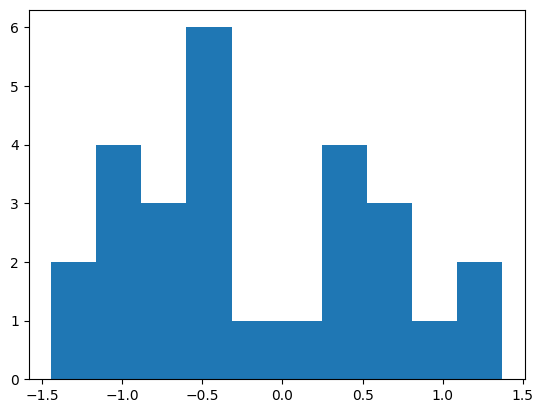

In [101]:
plt.hist(logits[0].cpu().detach().numpy())

In [96]:
h.shape

torch.Size([32, 200])

(array([856., 338., 218., 159., 139., 148.,  98., 117.,  68.,  85.,  91.,
         83.,  77.,  87.,  57.,  60.,  77.,  71.,  62.,  55.,  84.,  68.,
         47.,  58.,  74.,  62.,  75.,  55.,  48.,  59.,  83.,  61.,  77.,
         59.,  66.,  57.,  76.,  97.,  81., 101.,  78., 117.,  93., 120.,
        121., 126., 144., 240., 305., 722.]),
 array([-9.99994159e-01, -9.59994936e-01, -9.19995713e-01, -8.79996490e-01,
        -8.39997268e-01, -7.99998045e-01, -7.59998822e-01, -7.19999599e-01,
        -6.80000377e-01, -6.40001154e-01, -6.00001931e-01, -5.60002708e-01,
        -5.20003486e-01, -4.80004263e-01, -4.40005040e-01, -4.00005817e-01,
        -3.60006595e-01, -3.20007372e-01, -2.80008149e-01, -2.40008926e-01,
        -2.00009704e-01, -1.60010481e-01, -1.20011258e-01, -8.00120354e-02,
        -4.00128126e-02, -1.35898590e-05,  3.99856329e-02,  7.99848557e-02,
         1.19984078e-01,  1.59983301e-01,  1.99982524e-01,  2.39981747e-01,
         2.79980969e-01,  3.19980192e-01,  3.59979

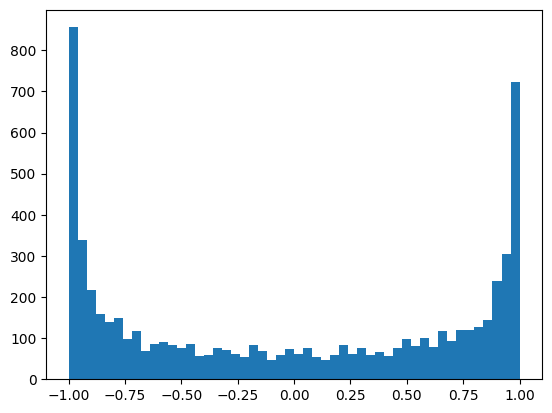

In [153]:
# saturation of the tanh
# need to make sure what gets in the tanh is between -1 and 1, otherwsie
# the delts between 10 and 100 in tanh won't be different
plt.hist(h.view(-1).tolist(), 50)

In [152]:
preact_h.std(), W1.std(), b1.std(), h.std()

(tensor(1.6745, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.3009, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.0202, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.7589, device='cuda:0', grad_fn=<StdBackward0>))

(array([  4.,   0.,   0.,   1.,   2.,   3.,   7.,  15.,  13.,  25.,  32.,
         48.,  48.,  75.,  87., 100., 130., 157., 201., 206., 252., 259.,
        291., 312., 343., 351., 389., 357., 340., 360., 334., 256., 240.,
        241., 196., 172., 144., 110.,  79.,  67.,  42.,  39.,  26.,  12.,
         16.,   5.,   6.,   3.,   2.,   2.]),
 array([-6.36965036, -6.13213553, -5.8946207 , -5.65710588, -5.41959105,
        -5.18207622, -4.94456139, -4.70704656, -4.46953173, -4.2320169 ,
        -3.99450207, -3.75698724, -3.51947241, -3.28195758, -3.04444275,
        -2.80692792, -2.56941309, -2.33189826, -2.09438343, -1.8568686 ,
        -1.61935377, -1.38183894, -1.14432411, -0.90680928, -0.66929445,
        -0.43177962, -0.19426479,  0.04325004,  0.28076487,  0.5182797 ,
         0.75579453,  0.99330935,  1.23082418,  1.46833901,  1.70585384,
         1.94336867,  2.1808835 ,  2.41839833,  2.65591316,  2.89342799,
         3.13094282,  3.36845765,  3.60597248,  3.84348731,  4.08100214,
 

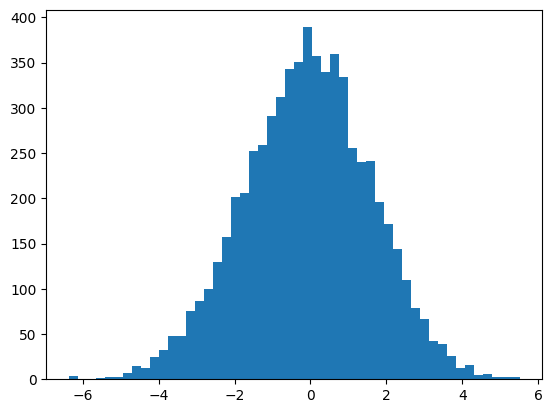

In [148]:
plt.hist(preact_h.view(-1).tolist(), 50)

In [79]:
h.abs().cpu().shape

torch.Size([182441, 200])

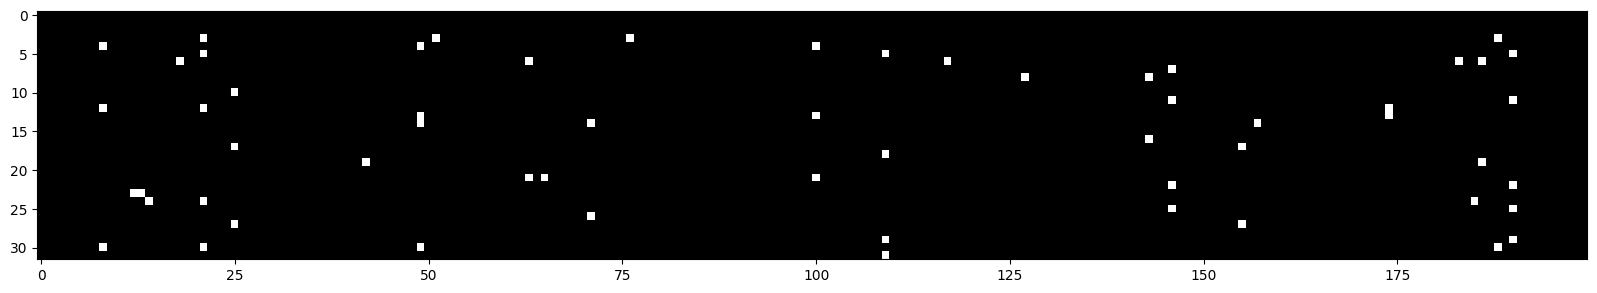

In [120]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs().cpu() > 0.99, cmap='gray', interpolation='nearest')

# dead neurons

## Inference

In [249]:
@torch.no_grad()
def inference():
    sentence, end_token = [".", ".", "."], False
    while not end_token:
        context_ixs = [stoi[x] for x in sentence[-3:]]
        x_inference = torch.tensor(context_ixs, dtype=torch.int)
        emb = C[x_inference]
        final_layer = torch.tanh(emb.view(1, block_size * embedding_size) @ W1 + b1) @ W2 + b2
        probabilities = torch.exp(final_layer) / torch.sum(torch.exp(final_layer), axis=1, keepdim=True)
        next_letter = itos[torch.multinomial(probabilities, num_samples=1).item()]
        sentence.append(next_letter)
        if next_letter == '.':
            end_token = True
    print(''.join(sentence))

for _ in range(50):
    inference()

...wan.
...lyne.
...zilan.
...taery.
...ceshadiq.
...alexne.
...avariuszensana.
...dat.
...kinz.
...harumiak.
...della.
...chalet.
...brenece.
...surit.
...azimwantelynnselin.
...domemy.
...ruressofine.
...ream.
...mammyne.
...yshom.
...danna.
...cane.
...sha.
...suanne.
...aza.
...kimior.
...sukusanajael.
...cera.
...vaj.
...jenzyn.
...pous.
...arleske.
...jarrydinzanryona.
...grylyne.
...ivaley.
...medoringla.
...ladee.
...emry.
...athyniediusimiykalim.
...mariethadha.
...jemerraviand.
...tow.
...ija.
...taeene.
...guke.
...yub.
...anj.
...lel.
...jagba.
...rangiellan.


# Appendix

In [40]:
torch.cat([emb[:, i, :] for i in range(block_size)], 1).shape

torch.Size([32, 6])

In [43]:
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-0.1152, -1.1897, -0.1152, -1.1897, -0.1152, -1.1897],
        [-0.1152, -1.1897, -0.1152, -1.1897,  0.2716,  1.0055],
        [-0.1152, -1.1897,  0.2716,  1.0055, -0.7203, -0.5304],
        [ 0.2716,  1.0055, -0.7203, -0.5304, -0.7203, -0.5304],
        [-0.7203, -0.5304, -0.7203, -0.5304,  0.2930,  0.3207],
        [-0.1152, -1.1897, -0.1152, -1.1897, -0.1152, -1.1897],
        [-0.1152, -1.1897, -0.1152, -1.1897,  1.3084,  0.0505],
        [-0.1152, -1.1897,  1.3084,  0.0505, -0.7158,  0.4897],
        [ 1.3084,  0.0505, -0.7158,  0.4897, -1.0853,  2.4026],
        [-0.7158,  0.4897, -1.0853,  2.4026,  0.0674, -0.0325],
        [-1.0853,  2.4026,  0.0674, -0.0325, -1.0853,  2.4026],
        [ 0.0674, -0.0325, -1.0853,  2.4026,  0.2930,  0.3207],
        [-0.1152, -1.1897, -0.1152, -1.1897, -0.1152, -1.1897],
        [-0.1152, -1.1897, -0.1152, -1.1897,  0.2930,  0.3207],
        [-0.1152, -1.1897,  0.2930,  0.3207,  0.0674, -0.0325],
        [ 0.2930,  0.3207,  0.0674, -0.0

In [48]:
a = torch.arange(18)
a.shape

torch.Size([18])

In [49]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [52]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [55]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T